In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
df=pd.read_csv('df_jepx_spotsum.csv',usecols=[0,7])

# # Ensure DATETIME is in datetime format and sort the data
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME', inplace=True)

# We focus only on the SYSTEM_PRICE for the LSTM model
prices = df['SYSTEM_PRICE'].values.reshape(-1, 1)

In [5]:
# NP = (prices- prices.min()) / (prices.max() - prices.min())
NP = prices

In [6]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
sequence_length = 1

In [8]:
X, y = create_sequences(NP, sequence_length)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM modelm
model = Sequential()                    
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
# Due to resource limitations, we will limit the number of epochs and batch size
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_test, y_test))

# Summarize the model's architecture
model.summary()



Epoch 1/15

4073/4073 [==============================] - 72s 14ms/step - loss: 10.4406 - val_loss: 4.2395
Epoch 2/15
4073/4073 [==============================] - 58s 14ms/step - loss: 5.8938 - val_loss: 3.3654
Epoch 3/15
4073/4073 [==============================] - 86s 21ms/step - loss: 6.3056 - val_loss: 4.5847
Epoch 4/15
4073/4073 [==============================] - 68s 17ms/step - loss: 5.3253 - val_loss: 3.3756
Epoch 5/15
4073/4073 [==============================] - 60s 15ms/step - loss: 5.3665 - val_loss: 3.6063
Epoch 6/15
4073/4073 [==============================] - 56s 14ms/step - loss: 5.7448 - val_loss: 4.4266
Epoch 7/15
4073/4073 [==============================] - 58s 14ms/step - loss: 5.7256 - val_loss: 3.2990
Epoch 8/15
4073/4073 [==============================] - 56s 14ms/step - loss: 5.0659 - val_loss: 5.6663
Epoch 9/15
4073/4073 [==============================] - 57s 14ms/step - loss: 5.6917 - val_loss: 4.6554
Epoch 10/15
4073/4073 [==============================] - 54s

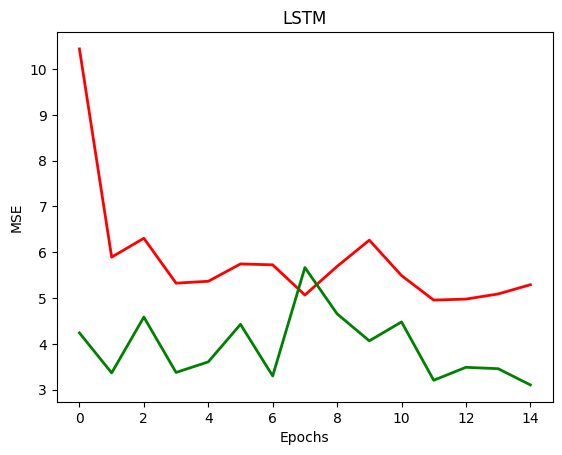

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
predicted_prices = model(X_test)

In [13]:
predicted_prices

<tf.Tensor: shape=(65165, 1), dtype=float32, numpy=
array([[13.894476 ],
       [12.170606 ],
       [ 6.118926 ],
       ...,
       [ 6.8227167],
       [ 6.4086246],
       [ 7.2020283]], dtype=float32)>

In [14]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(predicted_prices, y_test)
MAE

3.1031121595754665

In [15]:
from sklearn.metrics import r2_score
R2=r2_score(predicted_prices, y_test)
R2

0.9506307052263429

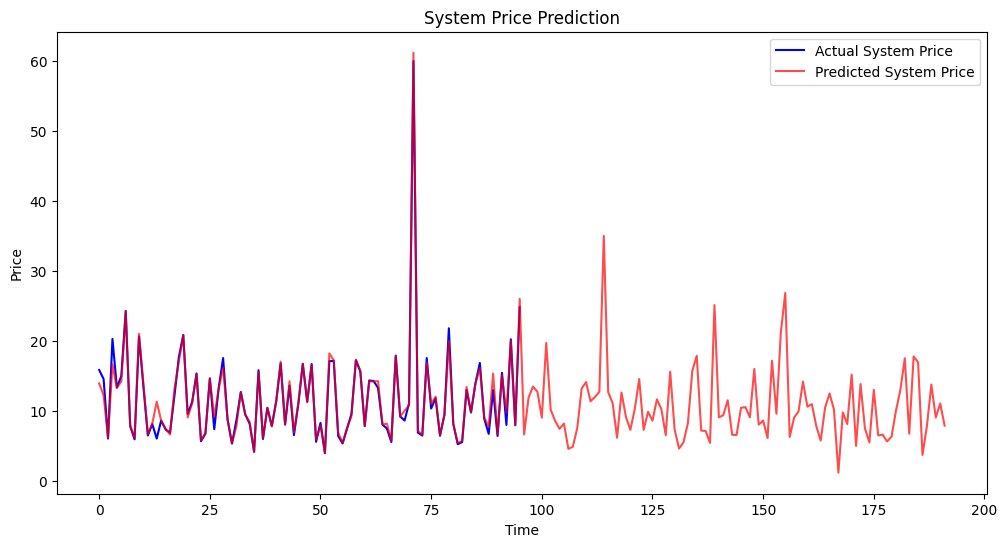

In [16]:
import matplotlib.pyplot as plt

# Plotting the actual and predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test[:96], color='blue', label='Actual System Price')
plt.plot(predicted_prices[:192], color='red', alpha=0.7, label='Predicted System Price')
plt.title('System Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
y_test

array([[15.81],
       [14.52],
       [ 6.  ],
       ...,
       [ 6.76],
       [ 6.24],
       [ 7.14]])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26056\346696427.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['signal'][i] == 1 and position <= 0:
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26056\346696427.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['signal'][i] == -1 and position > 0:
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26056\346696427.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

KeyboardInterrupt: 

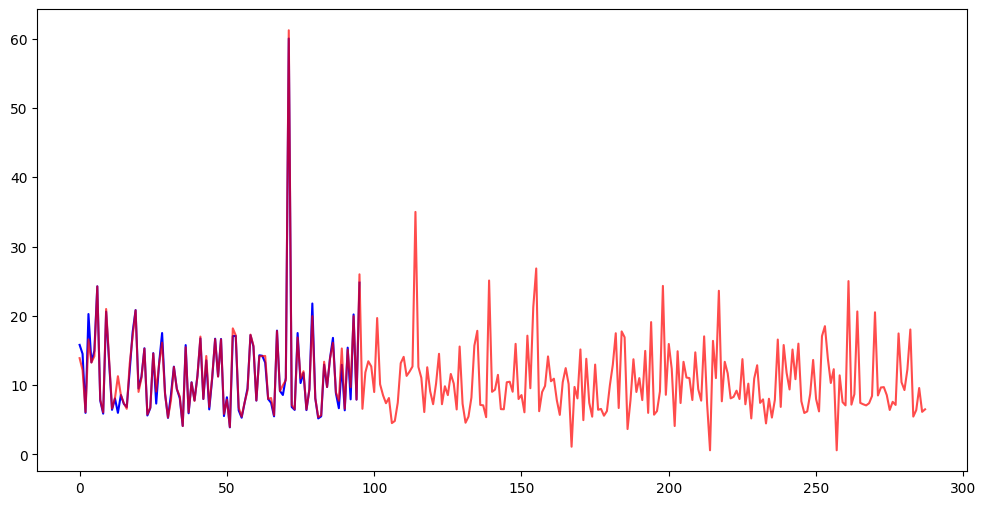

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize balance and position tracking
initial_balance = 10000 # Starting balance in dollars
balance = initial_balance
position = 0  # Current position
df['balance'] = initial_balance
# Plotting the actual and predicted prices


plt.figure(figsize=(12, 6))
plt.plot(y_test[:96], color='blue', label='Actual System Price')
plt.plot(predicted_prices[:288], color='red', alpha=0.7, label='Predicted System Price')

# Backtest the strategy
for i in range(288):
    actual_price = y_test[i]
    predicted_price = predicted_prices[i + 96]  # เปลี่ยนจาก 96 เป็น 48

# ตรวจสอบสัญญาณซื้อหรือขาย
    if predicted_price > actual_price:
        buy_signal = True
        sell_signal = False
    else:
        buy_signal = False
        sell_signal = True

# ดำเนินการซื้อหรือขาย
for i in range(1, len(df)):
    if df['signal'][i] == 1 and position <= 0:
        # Buy
        position += balance / df['SYSTEM_PRICE'][i]
        balance = 0
    elif df['signal'][i] == -1 and position > 0:
        # Sell
        balance += position * df['SYSTEM_PRICE'][i]
        position = 0
    df['balance'][i] = balance + position * df['SYSTEM_PRICE'][i]

# # แสดงกราฟ
# plt.title('System Price Prediction with Trading Signals')
# plt.xlabel('DATETIME')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df['SYSTEM_PRICE'], label='System Price', alpha=0.5)
plt.plot(df['EMA_12'], label='EMA 12', alpha=0.5)
plt.plot(df['EMA_26'], label='EMA 26', alpha=0.5)
plt.scatter(df.loc[df['signal'] == 1].index, df.loc[df['signal'] == 1]['SYSTEM_PRICE'], label='Buy Signal', marker='^', color='green')
plt.scatter(df.loc[df['signal'] == -1].index, df.loc[df['signal'] == -1]['SYSTEM_PRICE'], label='Sell Signal', marker='v', color='red')
plt.title('Buy and Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()


# predicted_prics
plt.figure(figsize=(12, 6))
plt.plot(df['balance'], label='Total Balance')
plt.title('Total Balance Over DATETIME')
plt.xlabel('DATETIME')
plt.ylabel('Balance')
plt.legend()

plt.show()

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the date range for backtesting
start_date = '2021-01-02'  # Replace with your start date
end_date = '2023-08-01'    # Replace with your end date
data = df.loc[start_date:end_date]

# Calculate EMAs
df['EMA_12'] = df['SYSTEM_PRICE'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['SYSTEM_PRICE'].ewm(span=26, adjust=False).mean()

# Generate signals
df['signal'] = 0
previous_signal = 0

for i in range(1, len(df)):
    if df['EMA_12'][i] > df['EMA_26'][i] and previous_signal != 1:
        df['signal'][i] = 1  # Buy signal
        previous_signal = 1
    elif df['EMA_26'][i] > df['EMA_12'][i] and previous_signal != -1:
        df['signal'][i] = -1  # Sell signal
        previous_signal = -1

# Initialize balance and position tracking
initial_balance = 10000  # Starting balance in dollars
balance = initial_balance
position = 0  # Current position
df['balance'] = initial_balance

# Backtest the strategy
for i in range(1, len(df)):
    if df['signal'][i] == 1 and position <= 0:
        # Buy
        position += balance / df['SYSTEM_PRICE'][i]
        balance = 0
    elif df['signal'][i] == -1 and position > 0:
        # Sell
        balance += position * df['SYSTEM_PRICE'][i]
        position = 0
    df['balance'][i] = balance + position * df['SYSTEM_PRICE'][i]

# Plot Buy/Sell Signals on Price
plt.figure(figsize=(12, 6))
plt.plot(df['SYSTEM_PRICE'], label='System Price', alpha=0.5)
plt.plot(df['EMA_12'], label='EMA 12', alpha=0.5)
plt.plot(df['EMA_26'], label='EMA 26', alpha=0.5)
plt.scatter(df.loc[df['signal'] == 1].index, df.loc[df['signal'] == 1]['SYSTEM_PRICE'], label='Buy Signal', marker='^', color='green')
plt.scatter(df.loc[df['signal'] == -1].index, df.loc[df['signal'] == -1]['SYSTEM_PRICE'], label='Sell Signal', marker='v', color='red')
plt.title('Buy and Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Plot Total Balance Over Time
plt.figure(figsize=(12, 6))
plt.plot(data['balance'], label='Total Balance')
plt.title('Total Balance Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()

plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26056\2867883377.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['EMA_12'][i] > df['EMA_26'][i] and previous_signal != 1:
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26056\2867883377.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['EMA_26'][i] > df['EMA_12'][i] and previous_signal != -1:
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26056\2867883377.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

KeyboardInterrupt: 